#Détection de panaches dans la surveillance mobile de la qualité de l'air 🌫️ : regroupement spatial d'applications 🚗🌍
#(Detecting Plumes in Mobile Air Quality Monitoring Spatial Clustering of Applications)

Notre jeu de données se compose d'un fichier CSV riche et structuré, contenant **10 colonnes** informatives et **117 572 lignes** d'observations, offrant ainsi une base solide pour notre analyse. 📊✨

**Ce dataset vise à surveiller la qualité de l'air dans les différentes régions ciblées en utilisant des mesures prises via des voitures** 🌍🚗.

 Les en-têtes de colonnes sont les suivants :

*   "Lat1" : Latitude GPS de l'emplacement de la voiture en degrés. 🌍 \

*   "Long1" : Longitude GPS de l'emplacement de la voiture en degrés. 🌐 \

*   "LST" : Horodatage de mesure. Fuseau horaire US/Central. ⏰ \

*   "BC" : Mesures de carbone noir en ng/m³. 🖤 \

*   "CO2" : Mesures de dioxyde de carbone en ppm. 🌿 \

*   "UFP" : Nombre de particules ultrafines en particules/cc. 🌬️ \

*   "NOx" : Oxydes d'azote, définis comme la somme de NO et NO₂, en ppb. 💨 \

*   "Anomaly" : Ce qui a été manuellement signalé comme "Anomalie" (2) ou "Normal" (1). ⚠️✅ \

*   "Uniq_Fac" : Facteur de 1 à 30 qui correspond à différents jours de la campagne.

   Par exemple, toutes les mesures avec Uniq_Fac = 1 appartiennent au même jour. 📅






# Modules et importations 📦


In [ ]:
!pip install kneed==0.8.5

In [ ]:
!pip install folium

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import folium

# Analyse Exploratoire des Données (EDA) 🔍

In [ ]:
data = pd.read_csv('/content/Validated_Data.csv')
print(data.head())

   Unnamed: 0       Lat1      Long1                  LST          BC     CO2  \
0           1  29.725645 -95.401718  2017-07-07 13:14:11  837.000000  428.25   
1           2  29.725649 -95.401588  2017-07-07 13:14:12  781.714286  429.87   
2           3  29.725657 -95.401459  2017-07-07 13:14:13  815.750000  434.21   
3           4  29.725662 -95.401329  2017-07-07 13:14:14  801.333333  436.23   
4           5  29.725660 -95.401199  2017-07-07 13:14:15  787.200000  434.82   

       UFP       NOx  Anomaly  Uniq_Fac  
0  13300.0  8.200000      2.0       1.0  
1  13100.0  8.300913      2.0       1.0  
2  13200.0  8.413027      2.0       1.0  
3  13900.0  8.524685      2.0       1.0  
4  14600.0  8.624228      2.0       1.0  


In [ ]:
print(data['LST'][10000:150000])

10000   2017-07-12 11:09:35
10001   2017-07-12 11:09:36
10002   2017-07-12 11:09:37
10003   2017-07-12 11:09:38
10004   2017-07-12 11:09:39
                ...        
52826   2017-07-27 11:15:46
52827   2017-07-27 11:15:47
52828   2017-07-27 11:15:48
52829   2017-07-27 11:15:49
52830   2017-07-27 11:15:50
Name: LST, Length: 42831, dtype: datetime64[ns]


In [ ]:
data.drop(columns=['Unnamed: 0'], inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52832 entries, 0 to 52831
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Lat1      52832 non-null  float64
 1   Long1     52832 non-null  float64
 2   LST       52831 non-null  object 
 3   BC        52831 non-null  float64
 4   CO2       52831 non-null  float64
 5   UFP       52831 non-null  float64
 6   NOx       52831 non-null  float64
 7   Anomaly   52831 non-null  float64
 8   Uniq_Fac  52831 non-null  float64
dtypes: float64(8), object(1)
memory usage: 3.6+ MB


On doit convertir la colonne **LST** en un format de **datetime**.\
 Une fois cette conversion effectuée, on pourra facilement effectuer diverses manipulations telles que l'extraction de l'année, du mois, du jour, de l'heure, ou même faire des calculs sur la durée entre différentes dates...

## Missing values Handling ❌

🔍 Étape 1 : Détection des Lignes Incomplètes
On commence par rechercher toutes les lignes qui présentent une ou plusieurs valeurs manquantes. Cela nous donnera un aperçu global de l’étendue des valeurs manquantes dans notre DataFrame.

⚖️ Étape 2 : Suppression Conditionnelle
Si le nombre de lignes incomplètes est faible (en dessous d’un seuil acceptable), on les supprimera sans hésiter 🗑️. Cela garantit un nettoyage rapide et précis de notre jeu de données sans impacter significativement son volume.

Si le nombre de lignes manquantes est plus élevé, on pourra envisager d'autres options comme l’imputation pour conserver un maximum de données 🔄.

Nombre total de lignes avec des valeurs manquantes : 1
1 lignes avec valeurs manquantes ont été supprimées.


In [ ]:
data['LST'] = pd.to_datetime(data['LST'])
print(data['LST'])

0       2017-07-07 13:14:11
1       2017-07-07 13:14:12
2       2017-07-07 13:14:13
3       2017-07-07 13:14:14
4       2017-07-07 13:14:15
                ...        
52826   2017-07-27 11:15:46
52827   2017-07-27 11:15:47
52828   2017-07-27 11:15:48
52829   2017-07-27 11:15:49
52830   2017-07-27 11:15:50
Name: LST, Length: 52831, dtype: datetime64[ns]


# Data Scaling

 Let us start by assessing whether the variables show significant differences in their respective scales. 🌟

  Scale analysis allows to check if some variables dominate others in terms of magnitude, which could **influence the model in an unwanted way**. 📉📊

To do this, we **will** examine the **minimum and maximum values of each variable** to identify any differences in scales.

 *Once these disparities are identified, we can consider scaling techniques (scaling) to harmonize values and ensure consistent treatment in the model. * 🚀

## 1. Résumé statistique (méthode descriptive) 🧮

In [ ]:
data.describe()

,Lat1,Long1,LST,BC,CO2,UFP,NOx,Anomaly,Uniq_Fac
count,52831.000000,52831.000000,52831,52831.000000,52831.000000,52831.000000,52831.000000,52831.000000,52831.000000
mean,29.732458,-95.425242,2017-07-21 03:00:27.344381184,805.846297,418.723262,5316.669076,17.558479,1.270372,3.742310
min,29.697020,-95.539230,2017-07-07 13:14:11,-1066.737500,369.308750,2.526777,-11.437600,1.000000,1.000000
25%,29.715798,-95.418327,2017-07-12 12:05:11.500000,256.900000,400.850000,259.000000,4.434000,1.000000,2.000000
50%,29.720230,-95.412804,2017-07-24 11:14:34,448.500000,406.640000,1390.000000,7.400000,1.000000,4.000000
75%,29.724844,-95.404678,2017-07-27 10:01:46,717.200000,422.465000,8850.000000,14.750821,2.000000,5.000000
max,29.814898,-95.337257,2017-07-27 13:48:09,52463.700000,1538.840000,100224.362735,541.400000,2.000000,6.000000
std,0.032282,0.054482,NaN,2022.813043,35.237241,8485.191637,34.127084,0.444156,1.505305


Le dataset obtenu ci-dessus, présente une grande variété de valeurs dans les mesures environnementales (🌍 BC, CO2, UFP, NOx), avec **des échelles qui divergent fortement** et des écarts-types élevés, surtout pour BC et UFP.

**Cette disparité pourrait influencer les résultats de manière imprévue** 🔍.

Par conséquent, une étape de data scaling ✨ est essentielle pour harmoniser les valeurs et garantir une analyse plus cohérente.

 Cette préparation facilitera une modélisation stable et précise dans les étapes à venir, en rendant les valeurs comparables et prêtes pour l’entraînement du modèle. 🚀

NB ❗ Pour la caractéristique **Long1** : les valeurs sont négatives car les voitures se trouvent à **l'ouest du méridien de Greenwich**. \
Dans cette zone, les longitudes sont exprimées entre 0° et -180°, comme c’est le cas pour les Amériques.

## 2. Data Distribution plot

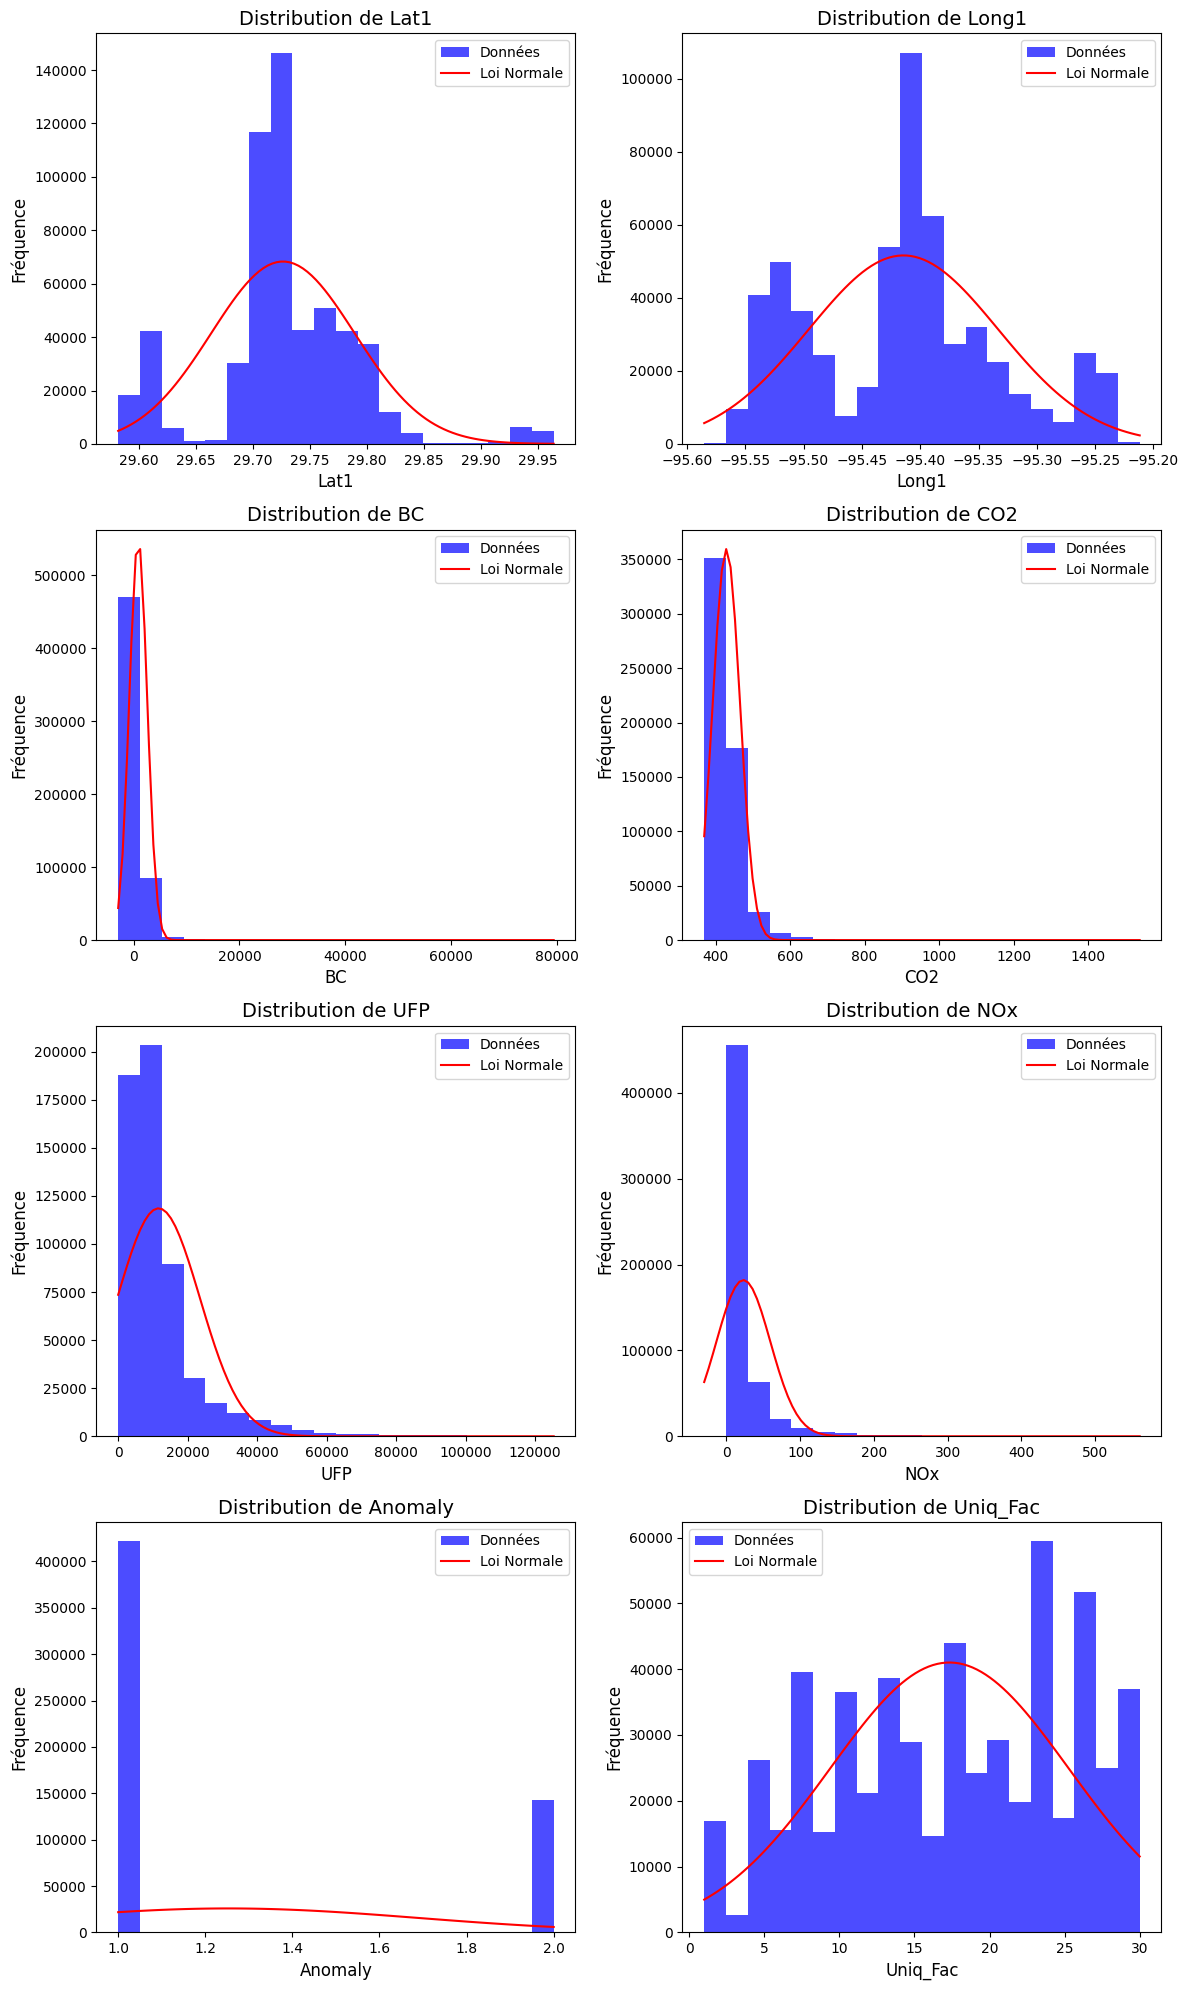

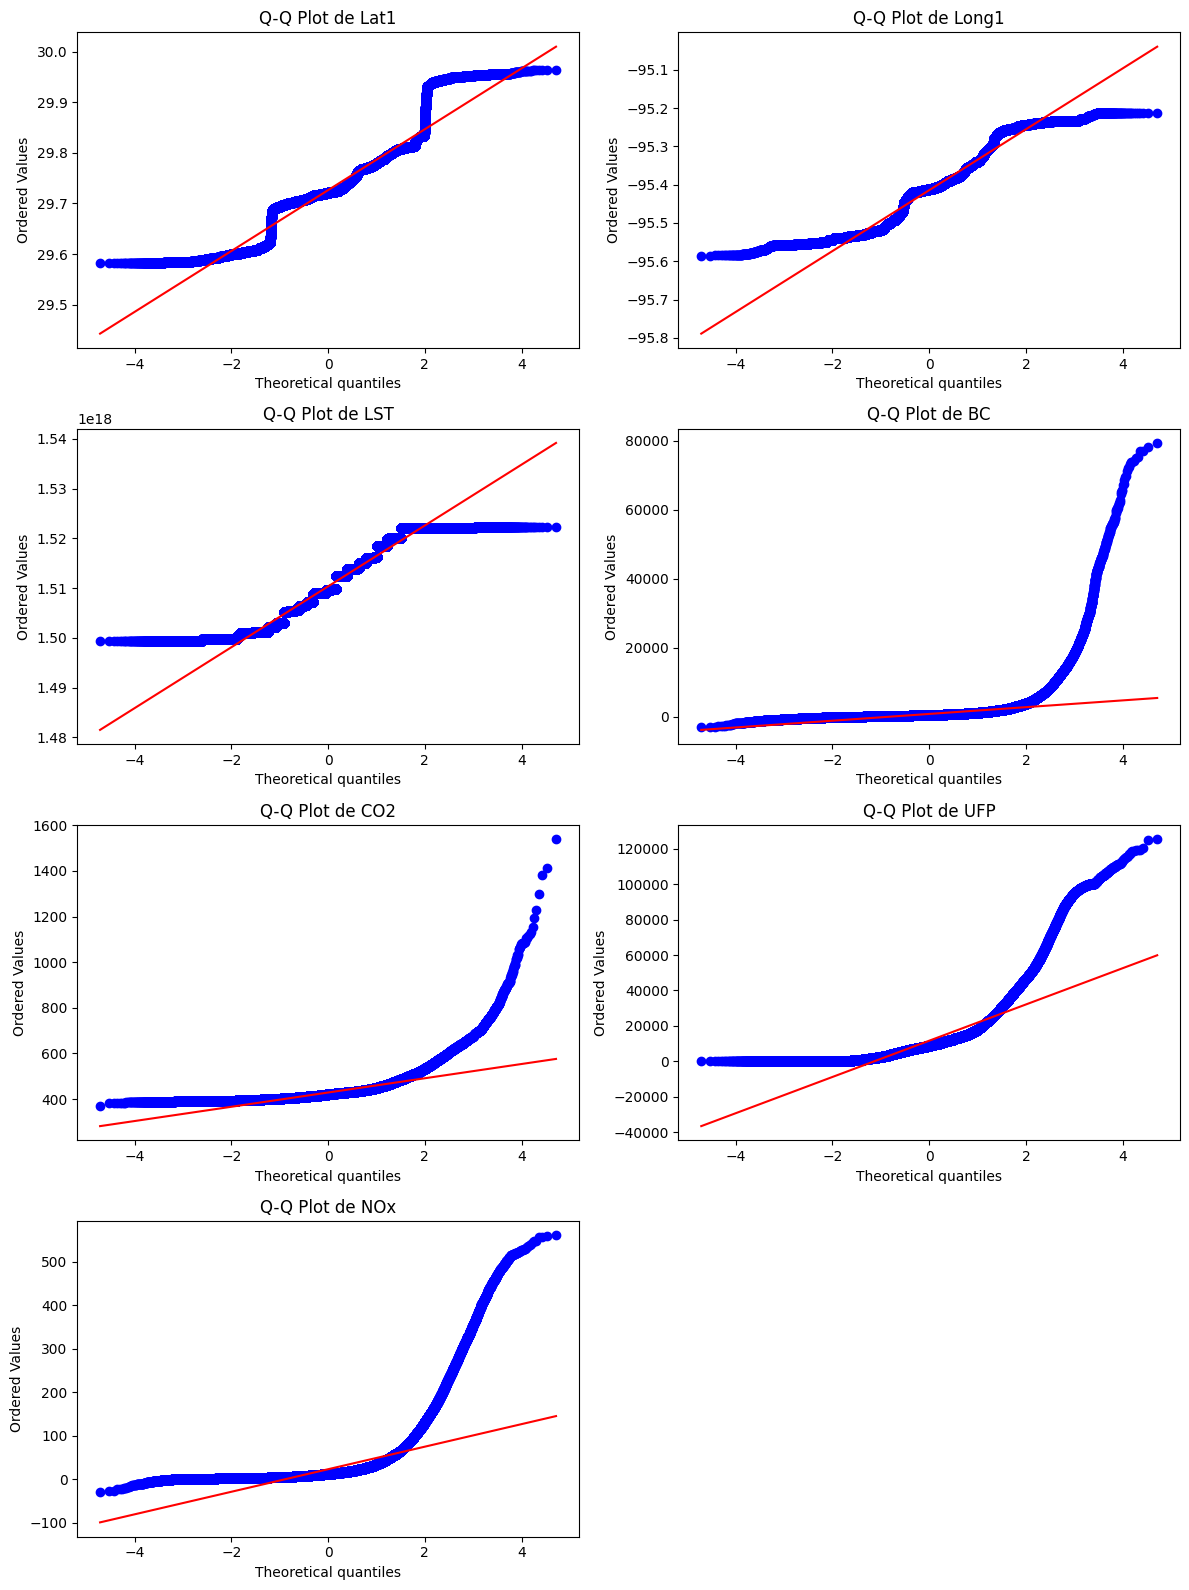

       Lat1     Long1        BC       CO2       UFP       NOx  Anomaly  \
0  0.242836  0.680843  0.035564  0.050397  0.132680  0.035521      1.0   
1  0.242870  0.681487  0.034531  0.051782  0.130685  0.035704      1.0   
2  0.242938  0.682126  0.035167  0.055493  0.131683  0.035907      1.0   
3  0.242980  0.682769  0.034897  0.057221  0.138667  0.036109      1.0   
4  0.242963  0.683413  0.034633  0.056015  0.145652  0.036289      1.0   

   Uniq_Fac  
0       0.0  
1       0.0  
2       0.0  
3       0.0  
4       0.0  


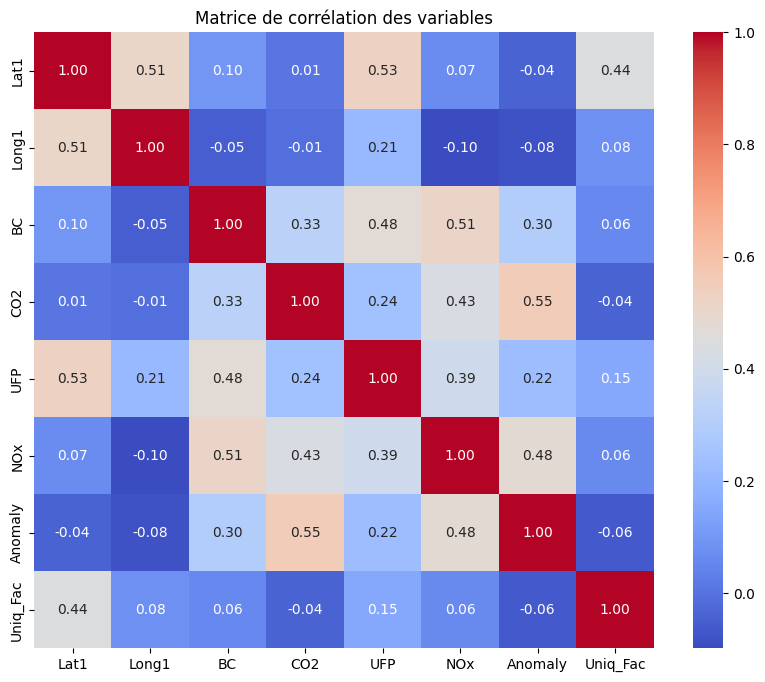

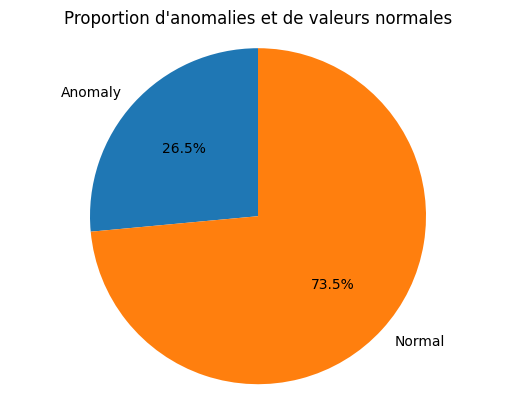

,Lat1,Long1,BC,CO2,UFP,NOx,Uniq_Fac
count,52831.000000,52831.000000,52831.000000,52831.000000,52831.000000,52831.000000,52831.000000
mean,0.300636,0.564374,0.034982,0.042252,0.053024,0.052450,0.548462
std,0.273859,0.269749,0.037788,0.030129,0.084664,0.061731,0.301061
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.159300,0.598610,0.024727,0.026969,0.002559,0.028709,0.200000
50%,0.196898,0.625955,0.028306,0.031920,0.013844,0.034074,0.600000
75%,0.236041,0.666188,0.033326,0.045451,0.088279,0.047371,0.800000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Deux paramètres clés de l'algorithme DBSCAN 🌌 :

- eps (epsilon) : la distance maximale entre deux points pour qu'ils soient considérés comme voisins.\
Ce paramètre est crucial pour définir la densité des clusters.
- MinPts : le nombre minimum de points nécessaires pour qu'un groupe de points soit reconnu comme un cluster.\

Étant donné que DBSCAN est un algorithme non supervisé, il n'est pas possible de faire du tuning de paramètres classique.

Cependant, pour déterminer la valeur optimale de **eps**, on va utiliser le **k-distance plot** 📉, qui permet d'analyser les distances et de trouver un **point d'inflexion** indiquant la **valeur d’eps idéale**.

Pour **MinPts**, une bonne approche consiste à démarrer avec 2 fois le nombre de caractéristiques du dataset.
*(Sander et al., 1998)*. 📊

 Ensuite, on ajuste ce paramètre progressivement pour optimiser les résultats du modèle 🛠️.

 Cette méthode permet d'améliorer la qualité des clusters et de mieux détecter les structures de données.



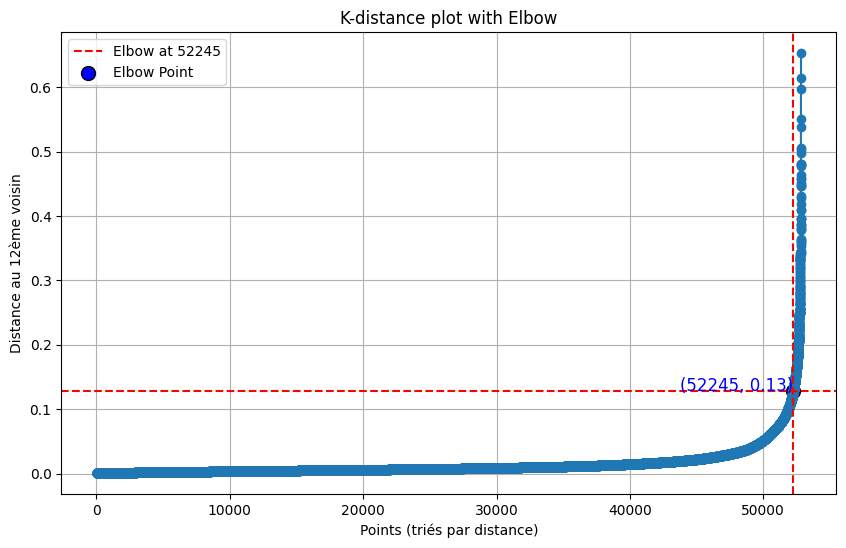

0.1282885973655814


cluster
 1    14349
 6    11282
 3    10033
 8     6945
 4     4370
 2     2663
 0     2594
-1      312
 7      226
 5       57
Name: count, dtype: int64


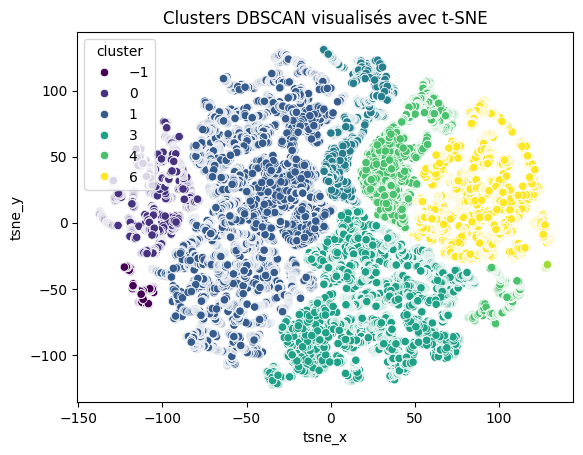

In [ ]:
new_df.head()

,Lat1,Long1,BC,CO2,UFP,NOx,Uniq_Fac,cluster
0,0.242836,0.680843,0.035564,0.050397,0.132680,0.035521,0.0,0
1,0.242870,0.681487,0.034531,0.051782,0.130685,0.035704,0.0,0
2,0.242938,0.682126,0.035167,0.055493,0.131683,0.035907,0.0,0
3,0.242980,0.682769,0.034897,0.057221,0.138667,0.036109,0.0,0
4,0.242963,0.683413,0.034633,0.056015,0.145652,0.036289,0.0,0


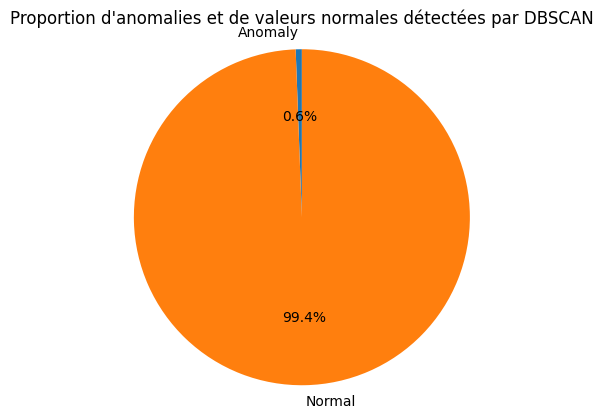

       Lat1     Long1        BC       CO2       UFP       NOx  Uniq_Fac  \
0  0.242836  0.680843  0.035564  0.050397  0.132680  0.035521       0.0   
1  0.242870  0.681487  0.034531  0.051782  0.130685  0.035704       0.0   
2  0.242938  0.682126  0.035167  0.055493  0.131683  0.035907       0.0   
3  0.242980  0.682769  0.034897  0.057221  0.138667  0.036109       0.0   
4  0.242963  0.683413  0.034633  0.056015  0.145652  0.036289       0.0   

   cluster  anomaly_score  anomaly_label  
0        0      -0.013695             -1  
1        0      -0.009667             -1  
2        0      -0.014375             -1  
3        0      -0.013961             -1  
4        0      -0.016730             -1  


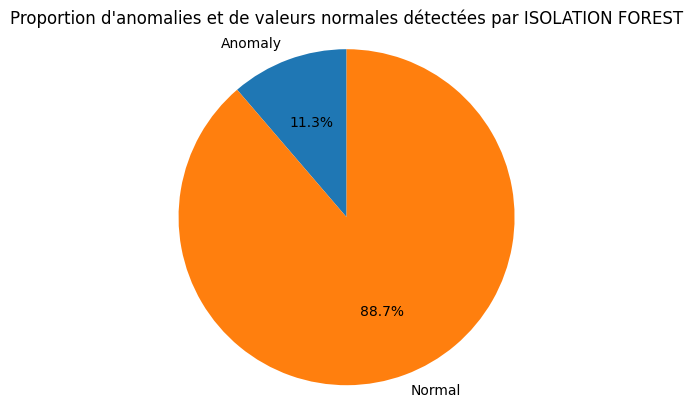

# One-class SVM 🌌
The One-Class SVM is an anomaly detection algorithm 🕵️ that uses the principles of the Support Vector Machine (SVM) to separate normal data from anomalies.

 Its goal is to find a boundary 📉 that surrounds the normal points in a high dimensional space, leaving the anomalies outside.

       Lat1     Long1        BC       CO2       UFP       NOx  Uniq_Fac  \
0  0.242836  0.680843  0.035564  0.050397  0.132680  0.035521       0.0   
1  0.242870  0.681487  0.034531  0.051782  0.130685  0.035704       0.0   
2  0.242938  0.682126  0.035167  0.055493  0.131683  0.035907       0.0   
3  0.242980  0.682769  0.034897  0.057221  0.138667  0.036109       0.0   
4  0.242963  0.683413  0.034633  0.056015  0.145652  0.036289       0.0   

   cluster  anomaly_score  anomaly_label  anomaly_label_One-Class-SVM  
0        0      -0.013695             -1                           -1  
1        0      -0.009667             -1                           -1  
2        0      -0.014375             -1                           -1  
3        0      -0.013961             -1                           -1  
4        0      -0.016730             -1                           -1  


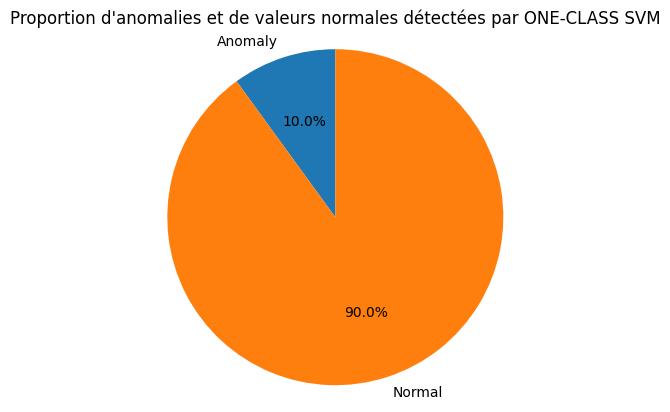

The visualization below illustrates the results of anomaly detection using the One-Class SVM algorithm, after applying dimensionality reduction with t-SNE. 📊

In the graph, points represent data observations, colored blue for normal 🔵 values and red for detected anomalies 🔴.
Decision contours, which are shaded areas, indicate the regions where the model considers the points to be normal (blue) or abnormal (red).

This representation clearly visualizes the distribution of anomalies in the reduced space of t-NES, showing how they differ from normal data. ✨

This helps to understand the effectiveness of the algorithm in identifying atypical behaviors within the analyzed data. 📈

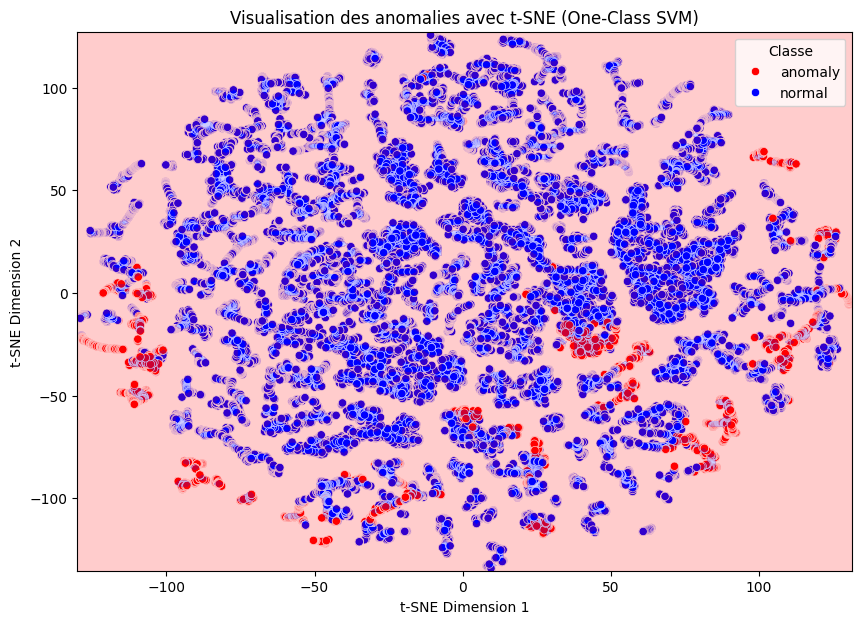

   cluster  cluster_remapped
0        0                 0
1        0                 0
2        0                 0
3        0                 0
4        0                 0


   anomaly_label  anomaly_label_remapped
0             -1                       1
1             -1                       1
2             -1                       1
3             -1                       1
4             -1                       1


   anomaly_label_One-Class-SVM  anomaly_label_One-Class-SVM_remapped
0                           -1                                     1
1                           -1                                     1
2                           -1                                     1
3                           -1                                     1
4                           -1                                     1


<ipython-input-28-a59c100383b8>:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_row], ignore_index=True)


              Model  Precision    Recall  F1 Score   AUC ROC
0            DBSCAN   1.000000  0.021843  0.042751  0.510921
1  Isolation Forest   0.910660  0.380356  0.536593  0.683264
2     One-Class SVM   0.508895  0.188253  0.274836  0.560466


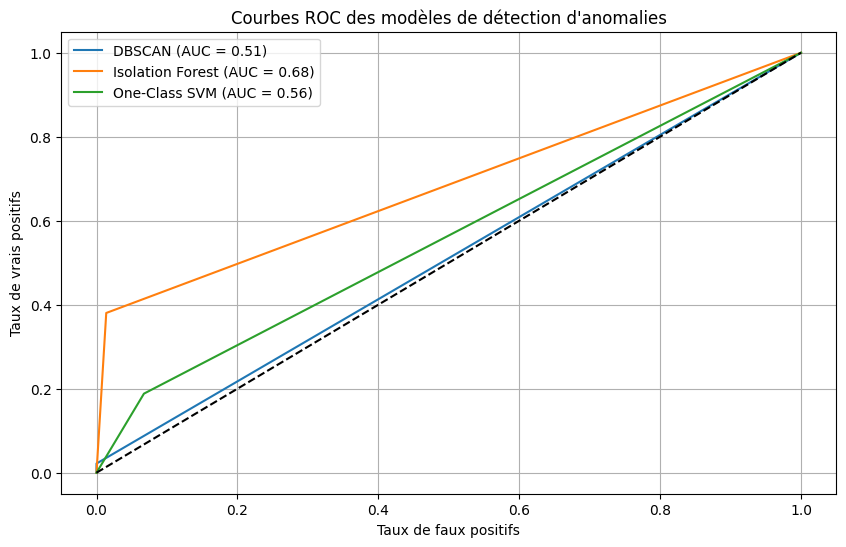

Given that we have the **geographic coordinates** of the locations where the Isolation Forest model detected **anomalies** 🌍✨—indicating a **high concentration of particles in the air**—let's explore the map of these points together to **visualize their geographic distribution** 🌫️📍!

In [ ]:
# Créer une carte Folium centrée sur la latitude et la longitude moyennes
map_center = [new_df['Lat1'].mean(), new_df['Long1'].mean()]
my_map = folium.Map(location=map_center, zoom_start=12)

# Ajouter des marqueurs pour les anomalies (rouge) et les points normaux (bleu)
for index, row in new_df.iterrows():
    if row['anomaly_label_remapped'] == 1:  # Anomalie
        folium.CircleMarker(
            location=[row['Lat1'], row['Long1']],
            radius=5,
            color='red',
            fill=True,
            fill_color='red',
            popup=f"Anomalie: {index}"  # Vous pouvez personnaliser le contenu de la popup
        ).add_to(my_map)
    else:  # Point normal
        folium.CircleMarker(
            location=[row['Lat1'], row['Long1']],
            radius=2,
            color='blue',
            fill=True,
            fill_color='blue',
            popup=f"Normal: {index}"  # Vous pouvez personnaliser le contenu de la popup
        ).add_to(my_map)

# Afficher la carte
my_map

Buffered data was truncated after reaching the output size limit.